In [260]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from pprint import pprint as pp 
from xgboost import XGBRegressor

In [2]:
import chardet
with open('EM-DATA-all.csv', 'rb') as f:
    result = chardet.detect(f.read())  #
result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [3]:
!ls


(base) C:\Users\work-02\Documents\git\BootlegForPeace>dir   
 Volume in drive C is OS
 Volume Serial Number is 6CCF-598B

 Directory of C:\Users\work-02\Documents\git\BootlegForPeace

17-Nov-18  06:07 PM    <DIR>          .
17-Nov-18  06:07 PM    <DIR>          ..
13-Nov-18  05:46 PM    <DIR>          .ipynb_checkpoints
14-Nov-18  10:11 PM         1,762,056 EM-DATA-all.csv
14-Nov-18  10:01 PM         1,762,075 EM-DATA-all.txt
10-Nov-18  05:06 AM         1,823,296 GPCC_DI_201810.nc
17-Nov-18  06:06 PM            79,486 hfg_eda.ipynb
14-Nov-18  10:22 PM        23,503,911 INFORM2019_TREND_2009_2019_v035_ALL_v2.csv
14-Nov-18  10:21 PM         9,827,132 INFORM2019_TREND_2009_2019_v035_ALL_v2.xlsx
17-Nov-18  03:17 PM               556 meeting notes.txt
18-Sep-07  06:03 PM        51,710,444 pdsi.monthly.maps.1870-2005.fawc=1.r2.5x2.5.nc
17-Nov-18  06:06 PM               104 README.md
17-Nov-18  12:22 PM        12,540,685 unhcr_popstats_export_asylum_seekers_monthly_all_data.csv
             

In [23]:
# import the dataset(s)
emdat = pd.read_csv('EM-DATA-all.csv', encoding='Windows-1252')
inform = pd.read_csv('INFORM2019_TREND_2009_2019_v035_ALL_v2.csv')
inform.columns

Index(['ISO', 'IndicatorId', 'IndicatorName', 'IndicatorScore',
       'IndicatorType', 'INFORMYear', 'DataYear'],
      dtype='object')

In [143]:
# pp(inform.sort_values('ISO').ISO.unique())
# emdat.sort_values('iso').iso.unique()

# Start here

In [5]:
# import refugee data
rdf = pd.read_csv('data/refugee_monthly.csv')
rdf.info()
rdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332189 entries, 0 to 332188
Data columns (total 5 columns):
Country / territory of asylum/residence    332189 non-null object
Origin                                     332189 non-null object
Year                                       332189 non-null int64
Month                                      332189 non-null object
Value                                      332189 non-null object
dtypes: int64(1), object(4)
memory usage: 12.7+ MB


C:\Users\work-02\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10
2,Australia,Afghanistan,1999,March,25
3,Australia,Afghanistan,1999,April,25
4,Australia,Afghanistan,1999,May,7


In [164]:
rdf.columns = ['Country', 'Origin', 'Year', 'Month', 'Value']
greece = rdf[rdf.Country == 'Greece']
tur = rdf[rdf.Country == 'Turkey']
ger = rdf[rdf.Country == 'Germany']
greece.head()

,Country,Origin,Year,Month,Value
6865,Greece,Afghanistan,1999,January,12
6866,Greece,Afghanistan,1999,February,9
6867,Greece,Afghanistan,1999,April,2
6868,Greece,Afghanistan,1999,May,27
6869,Greece,Afghanistan,1999,July,4


In [165]:
month_mapping = {'January':1, 'February':2, 'April':3, 'May':4, 'July':5, 'August':6,'September':7, 'October':8, 'November':9, 'June':10, 'March':11, 'December': 12}
greece.Month = greece.Month.map(month_mapping)
tur.Month = tur.Month.map(month_mapping)
ger.Month = ger.Month.map(month_mapping)
greece.head()

C:\Users\work-02\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Country,Origin,Year,Month,Value
6865,Greece,Afghanistan,1999,1,12
6866,Greece,Afghanistan,1999,2,9
6867,Greece,Afghanistan,1999,3,2
6868,Greece,Afghanistan,1999,4,27
6869,Greece,Afghanistan,1999,5,4


In [305]:
# Mitnaka
irq = rdf[rdf.Origin == 'Iraq']
irq.Month = irq.Month.map(month_mapping)
irq.Value = irq.Value.replace('*', 2)
irq.Value = irq.Value.astype(int)
irqext = irq[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
zub = grcgrp
zub['Irq'] = irqext.Value
zub

C:\Users\work-02\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Year,Month,Value,Irq
0,1999,1,167,3277
1,1999,2,80,2431
2,1999,3,66,2749
3,1999,4,183,2542
4,1999,5,65,2954
5,1999,6,65,2780
6,1999,7,257,3282
7,1999,8,157,3175
8,1999,9,160,3272
9,1999,10,152,2598


In [9]:
# split df into multiple dfs
splits = []
for cntr in greece.Origin.unique():
    splits.append(greece[greece.Origin == cntr])

for i in range(len(splits)):
    pp('{} {}'.format(len(splits[i])))
# len(splits)

In [170]:
greece.Value = greece.Value.replace('*', 2)
greece.Value = greece.Value.astype(int)
tur.Value = tur.Value.replace('*', 2)
tur.Value = tur.Value.astype(int)
ger.Value = ger.Value.replace('*', 2)
ger.Value = ger.Value.astype(int)

C:\Users\work-02\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [289]:
grcgrp = greece[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
turgrp = tur[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
gergrp = ger[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
# pp(gergrp.Value.sum())

# trimming
grcgrp = grcgrp[:-1]
turgrp = turgrp[:-1]
gergrp = gergrp[:-1]

data = [grcgrp, turgrp, gergrp]

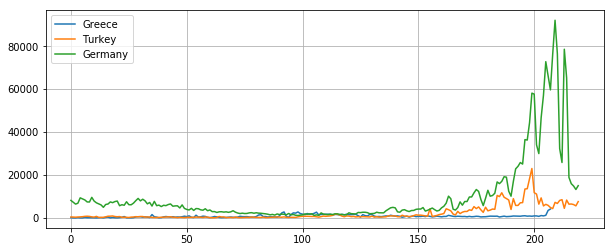

In [290]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.plot(grcgrp.Value.tolist(), label = 'Greece')
plt.plot(turgrp.Value.tolist(), label = 'Turkey')
plt.plot(gergrp.Value.tolist(), label = 'Germany')
plt.legend()
plt.grid()

## Forecasting

In [41]:
from sklearn.model_selection import train_test_split

In [217]:
# window_size = 1
# y = grcgrp.Value[window_size:]
# # pp(y.head())
# pp(y.head())
# X = grcgrp.Value.shift(window_size)[window_size:]
# X = [[i] for i in X.tolist()]
# grcgrp.Value.shift(window_size)

1     80
2     66
3    183
4     65
5     65
Name: Value, dtype: int32


In [267]:
def create_features(list_of_df, wndw=12, test_size=12):
    res = []
    for df in list_of_df:
        X = df
        for i in range(1, wndw):
            X['t-'+str(i)] = X.Value.shift(i)
        X = X[wndw-1:]
        y = X.Value
        X = X.drop(['Year','Month','Value'], axis=1)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=12)
        res.append(train_test_split(X, y, shuffle=False, test_size=12))

In [268]:
y = X.Value
X = X.drop(['Year','Month','Value'], axis=1)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=12)
# pp(X_train.head())
# y_train.head()

2230.949991861979


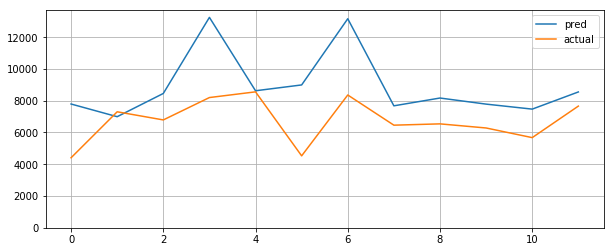

In [292]:
rgr = XGBRegressor()
rgr.fit(X_train, y_train.tolist())
preds = rgr.predict(X_test)
plt.plot(preds, label='pred')
plt.plot(y_test.tolist(), label='actual')
plt.ylim(ymin=0)
plt.legend()
plt.grid()
pp(mean_absolute_error(preds, y_test)/)

In [191]:
pp(y_test.head())
y_test.shift(1).head()

Year  Month
2015  5        1066
      6         881
      7         941
      8         847
      9        1001
Name: Value, dtype: int32


Year  Month
2015  5           NaN
      6        1066.0
      7         881.0
      8         941.0
      9         847.0
Name: Value, dtype: float64

C:\Users\work-02\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


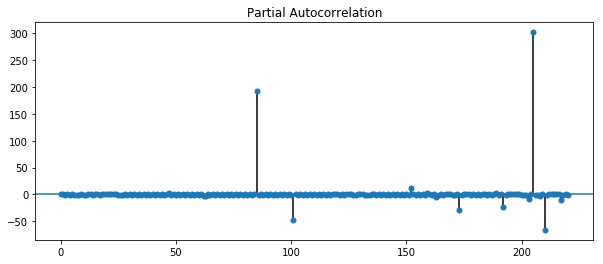

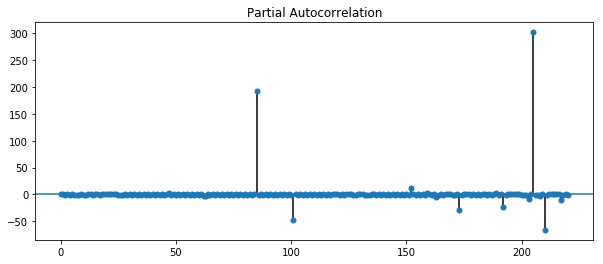

In [286]:
## Informed
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data[2].Value)